In [1]:
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from importlib import reload
from icedef import statoil_arcticnet_data as sd
from icedef import test_case, plot, simulator

In [2]:
plt.rcParams['figure.figsize'] = (12, 12)

In [3]:
def calc_mean_error(lats_lons, ref_lats_lons):
    
    # lats_lons and ref_lats_lons must be a list of xarray DataArrays with time as a dimension
    
    lats, lons = lats_lons
    ref_lats, ref_lons = ref_lats_lons
    
    n = len(ref_lats.values)
    
    errs = np.zeros(n)
    
    for i in range(n):
        ref_lat = ref_lats.values[i]
        ref_lon = ref_lons.values[i]
        time = ref_lats.time.values[i]
        lat = float(lats.interp(time=time, assume_sorted=True).values)
        lon = float(lons.interp(time=time, assume_sorted=True).values)
        errs[i] = np.sqrt((ref_lon - lon)**2 + (ref_lat - lat)**2)
    
    return np.mean(errs)

In [4]:
def plot_metocean_and_drift_track(field, velocity_field, lon_bounds, lat_bounds, time_bounds, tc):
    
    xs = field.data.longitude.values
    ys = field.data.latitude.values
    ts = field.data.time.values
    uos = velocity_field.eastward_velocities
    vos = velocity_field.northward_velocities

    xi = lon_bounds[0]
    xf = lon_bounds[1]
    yi = lat_bounds[0]
    yf = lat_bounds[1]
    ti = time_bounds[0]
    tf = time_bounds[1]
    xi_index = np.argmin(abs(xs - xi))
    xf_index = np.argmin(abs(xs - xf))
    yi_index = np.argmin(abs(ys - yi))
    yf_index = np.argmin(abs(ys - yf))
    ti_index = np.argmin(abs(ts - ti))
    tf_index = np.argmin(abs(ts - tf))

    xs = field.data.longitude.values[xi_index : xf_index + 1]
    ys = field.data.latitude.values[yi_index : yf_index + 1]
    ts = field.data.time.values[ti_index : tf_index + 1]
    uos = velocity_field.eastward_velocities.values[ti_index : tf_index + 1, yi_index : yf_index + 1, xi_index : xf_index + 1]
    vos = velocity_field.northward_velocities[ti_index : tf_index + 1, yi_index : yf_index + 1, xi_index : xf_index + 1]
    uos = np.mean(uos, axis=0)
    vos = np.mean(vos, axis=0)
    
    map_kwargs = plot.get_map_kwargs(ys[0], xs[0], ys[-1], xs[-1])
    map_ = plot.get_map(**map_kwargs)
    
    parallels = map_.drawparallels(np.arange(ys[0], ys[-1] + np.mean(np.diff(ys)), np.mean(np.diff(ys))),labels=[1,0,0,1])
    meridians = map_.drawmeridians(np.arange(xs[0], xs[-1] + np.mean(np.diff(xs)), np.mean(np.diff(xs))),labels=[1,0,0,1])
    for meridian in meridians:

        try:
            meridians[meridian][1][0].set_rotation(90)

        except IndexError:
            pass
    
    xs_, ys_ = map_(xs, ys)
    xs_1 = np.append(xs_, xs_[-1] + np.mean(np.diff(xs_))) - np.mean(np.diff(xs_)) / 2
    ys_1 = np.append(ys_, ys_[-1] + np.mean(np.diff(ys_))) - np.mean(np.diff(ys_)) / 2
    xxs, yys = np.meshgrid(xs_1, ys_1)
    #map_.imshow(np.sqrt(uos**2 + vos**2), origin='lower', interpolation='bicubic')
    map_.pcolor(xxs, yys, np.sqrt(uos**2 + vos**2))
    map_.quiver(xs_, ys_, uos, vos, units='xy', angles='xy')
    plt.colorbar()
    berg_xs = tc.ref_lons.values
    berg_ys = tc.ref_lats.values
    berg_xs_, berg_ys_ = map_(berg_xs, berg_ys)
    map_.scatter(berg_xs_, berg_ys_, color='r') 

In [5]:
def plot_cone(data, labels):
    
    ts = data['reference'].time.values
    lats = data['reference'].latitude.values
    lons = data['reference'].longitude.values
    sim_lats = np.empty((len(ts), len(labels)))
    sim_lons = np.empty((len(ts), len(labels)))

    for i in range(len(ts)):
        t = ts[i]
        for j, label in enumerate(labels):
            dat = data[label]
            sim_lats[i, j] = float(dat['latitude'].interp(time=t, assume_sorted=True).values)
            sim_lons[i, j] = float(dat['longitude'].interp(time=t, assume_sorted=True).values)

    fig = plt.figure(figsize=(16, 12))

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        mean_lats = np.mean(sim_lats, axis=1)
        mean_lons = np.mean(sim_lons, axis=1) 

        std1_lats = np.std(sim_lats, axis=1)
        std1_lons = np.std(sim_lons, axis=1)

        min1_lats = mean_lats - std1_lats
        min1_lons = mean_lons - std1_lons
        max1_lats = mean_lats + std1_lats
        max1_lons = mean_lons + std1_lons

        min2_lats = mean_lats - 2 * std1_lats
        min2_lons = mean_lons - 2 * std1_lons
        max2_lats = mean_lats + 2 * std1_lats
        max2_lons = mean_lons + 2 * std1_lons

        min3_lats = mean_lats - 3 * std1_lats
        min3_lons = mean_lons - 3 * std1_lons
        max3_lats = mean_lats + 3 * std1_lats
        max3_lons = mean_lons + 3 * std1_lons

        plt.plot(mean_lons, mean_lats, label='mean')

        polygon1_xys = np.column_stack((np.vstack((min1_lons, max1_lons[::-1])).ravel(), 
                                        np.vstack((min1_lats, max1_lats[::-1])).ravel()))
        polygon2_xys = np.column_stack((np.vstack((min2_lons, max2_lons[::-1])).ravel(), 
                                        np.vstack((min2_lats, max2_lats[::-1])).ravel()))
        polygon3_xys = np.column_stack((np.vstack((min3_lons, max3_lons[::-1])).ravel(), 
                                        np.vstack((min3_lats, max3_lats[::-1])).ravel()))

        polygon1 = Polygon(polygon1_xys, fill=True, alpha=0.2, label='σ1')
        polygon2 = Polygon(polygon2_xys, fill=True, alpha=0.2, label='σ2')
        polygon3 = Polygon(polygon3_xys, fill=True, alpha=0.2, label='σ3')

        ax = plt.gca()
        ax.add_patch(polygon1)
        ax.add_patch(polygon2)
        ax.add_patch(polygon3)

        ax.scatter(lons, lats, color='k')


        # ADDING TIME LINES
        for dt in np.arange(6, 24, 6):
            for min_lons, max_lons, min_lats, max_lats in zip([min1_lons, min2_lons, min3_lons], 
                                                                     [max1_lons, max2_lons, max3_lons],
                                                                     [min1_lats, min2_lats, min3_lats], 
                                                                     [max1_lats, max2_lats, max3_lats]):

                xr_min_lats = xr.DataArray(data=min_lats, coords=[ts], dims=['time'])
                xr_min_lons = xr.DataArray(data=min_lons, coords=[ts], dims=['time'])
                xr_max_lats = xr.DataArray(data=max_lats, coords=[ts], dims=['time'])
                xr_max_lons = xr.DataArray(data=max_lons, coords=[ts], dims=['time'])
                t = ts[0] + np.timedelta64(int(dt), 'h')
                xr_min_lat = float(xr_min_lats.interp(time=t, assume_sorted=True).values)
                xr_min_lon = float(xr_min_lons.interp(time=t, assume_sorted=True).values)
                xr_max_lat = float(xr_max_lats.interp(time=t, assume_sorted=True).values)
                xr_max_lon = float(xr_max_lons.interp(time=t, assume_sorted=True).values)
                plt.plot([xr_min_lon, xr_max_lon], [xr_min_lat, xr_max_lat], color='k', zorder=10)
            plt.annotate(s=f'{dt} hours in', xy=[xr_max_lon, xr_max_lat])

        #


        # ax.set_ylim(51.4, 51.65)
        ax.set_aspect('equal', adjustable='box')   

        plt.legend()

# Test Case B (Beacons 204980 and 906790)

In [6]:
beacon_id = '20498'
df = sd.get_beacon_df(beacon_id=beacon_id)

# Day 1

In [7]:
# note index 809 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[809]
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

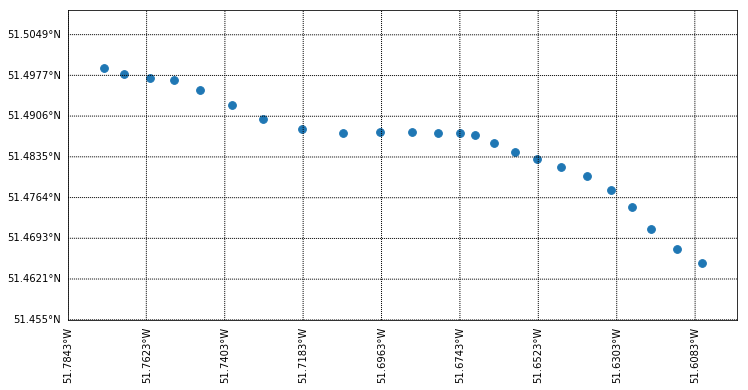

In [8]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

In [9]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

## Plotting metocean data

In [10]:
lon_bounds = (-52, -51.5) #(-52.5, -50.5)
lat_bounds = (51.2, 51.7) #(50.5, 52.5)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

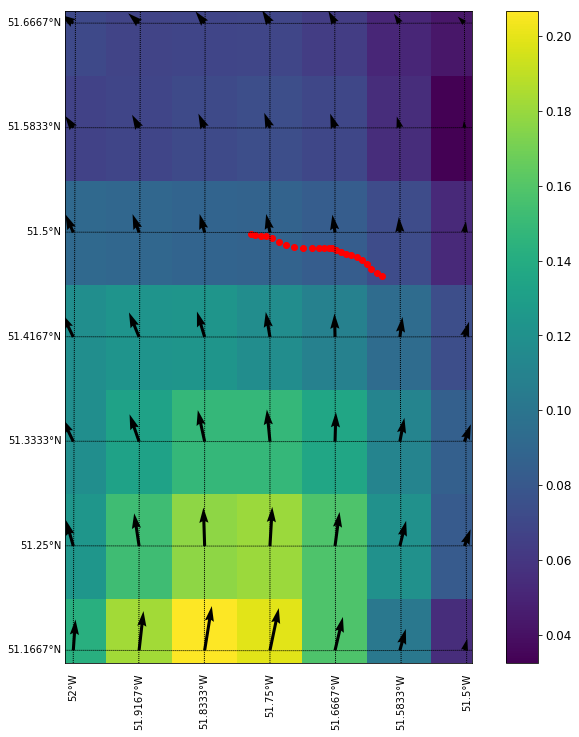

In [11]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds, tc)

In [12]:
lon_bounds = (-52.5, -50.5)
lat_bounds = (50.5, 52.5)

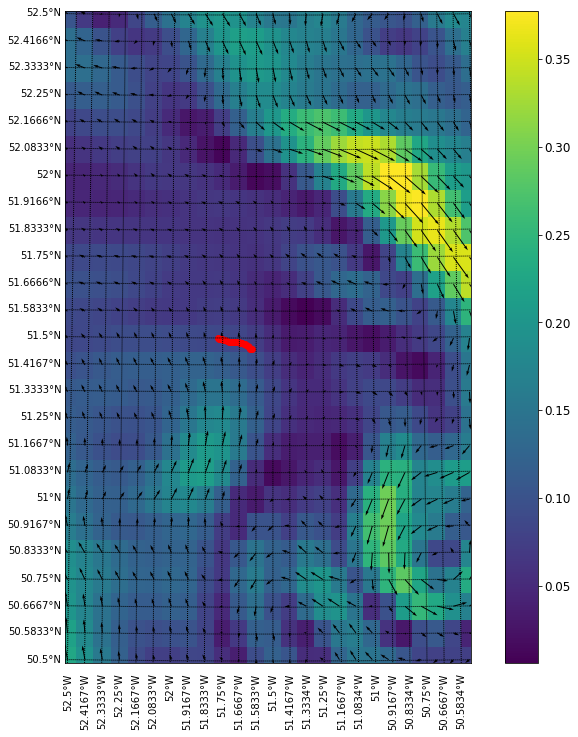

In [13]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds, tc)

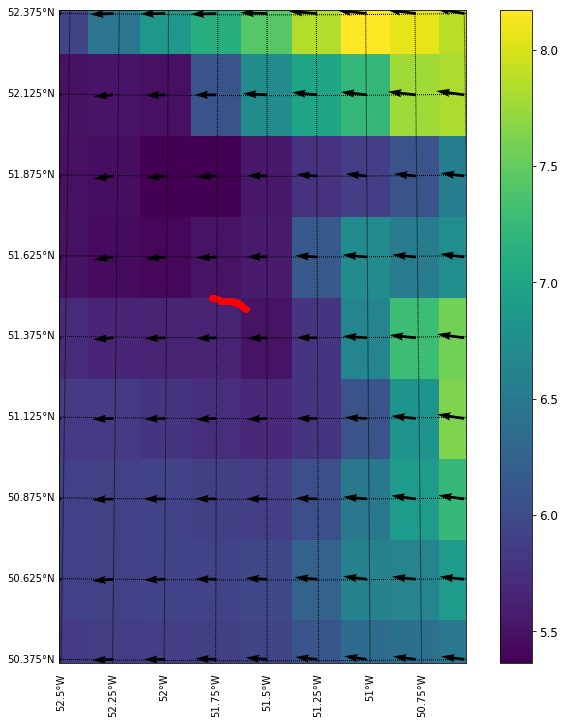

In [14]:
plot_metocean_and_drift_track(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds, tc)

## Find optimal Ca and Cw

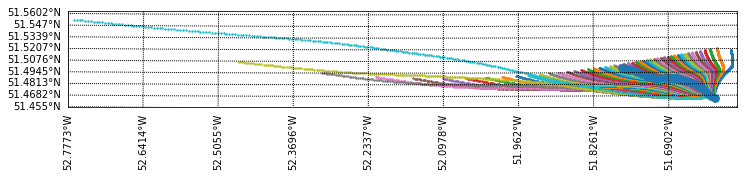

In [15]:
ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.00786211268939867, Ca: 1.4000000000000001, Cw: 1.0999999999999999


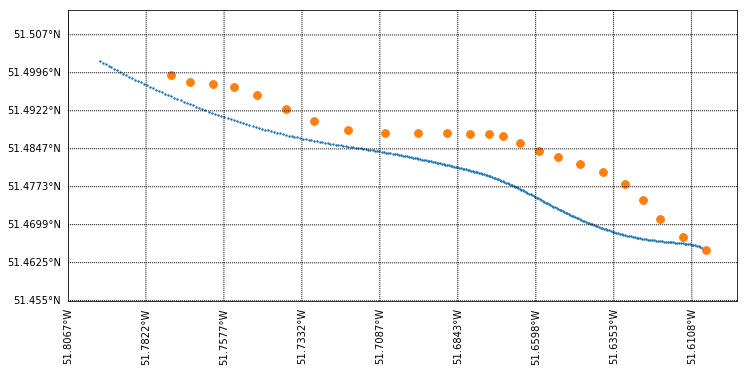

In [16]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    min_err = err_dict['err'][i][index]
    optimal_Ca = err_dict['Ca'][i][index]
    optimal_Cw = err_dict['Cw'][i][index]
    print('err: {}, Ca: {}, Cw: {}'.format(min_err, optimal_Ca, optimal_Cw))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

## Running Ensemble

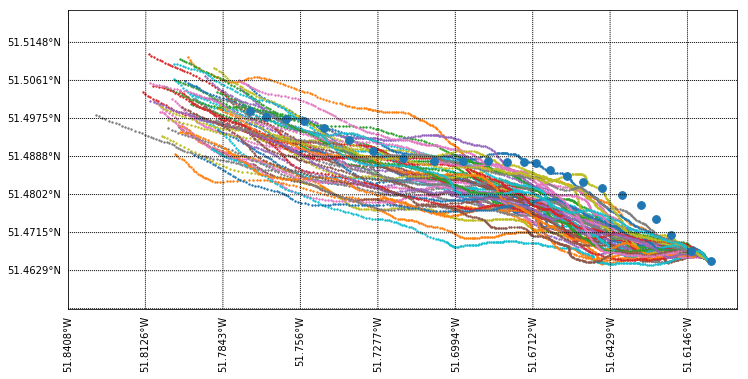

In [17]:
# sim_args = tc.time_frame, tc.start_location, tc.start_velocity
# sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
# reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
# sim.results.add_from_dict(reference_data_dict, label='reference')
# sim.testcase = tc

# ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = optimal_Ca, optimal_Cw
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}

N = 50

num_start_times = 1

for j in range(num_start_times):

    for i in range(N):

        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)


labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

## Plot Cone

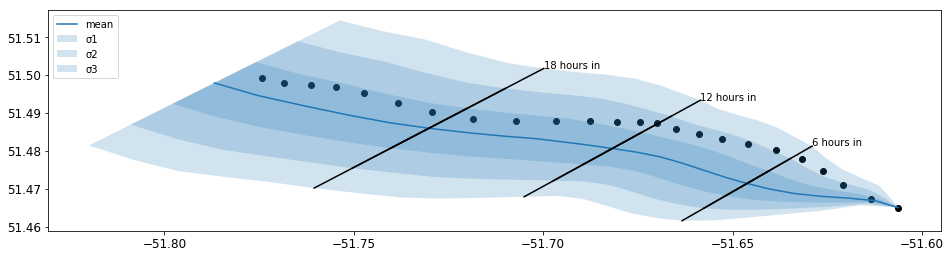

In [18]:
plot_cone(sim.results.data, [str(i) for i in range(N)])

# Test Case C (Beacons 505190 and 907780)

In [48]:
beacon_id = '50519'
df = sd.get_beacon_df(beacon_id=beacon_id)

# Day 1

In [49]:
# note index 537 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[537]
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

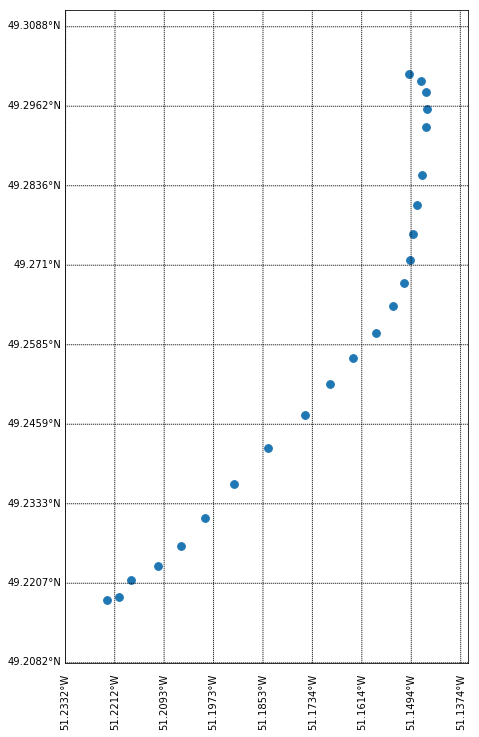

In [50]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

In [51]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc
g = sim.iceberg.geometry
g._size = None
g.sail_height = 12
g.waterline_length = 250
g.mass = 4.2e9

## Plotting metocean data

In [52]:
lon_bounds = (-51.5, -51)
lat_bounds = (49, 49.5)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

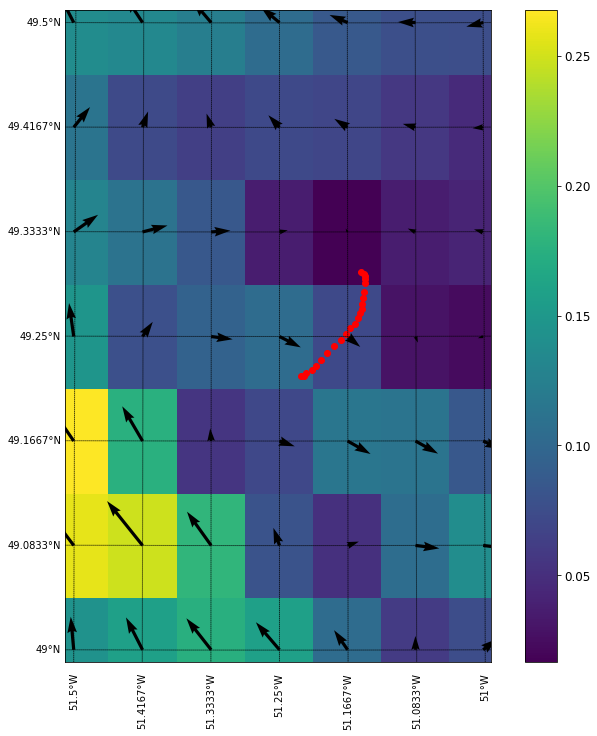

In [53]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds, tc)

In [54]:
lon_bounds = (-51.5-0.5, -51+0.5)
lat_bounds = (49-0.5, 49.5+0.5)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

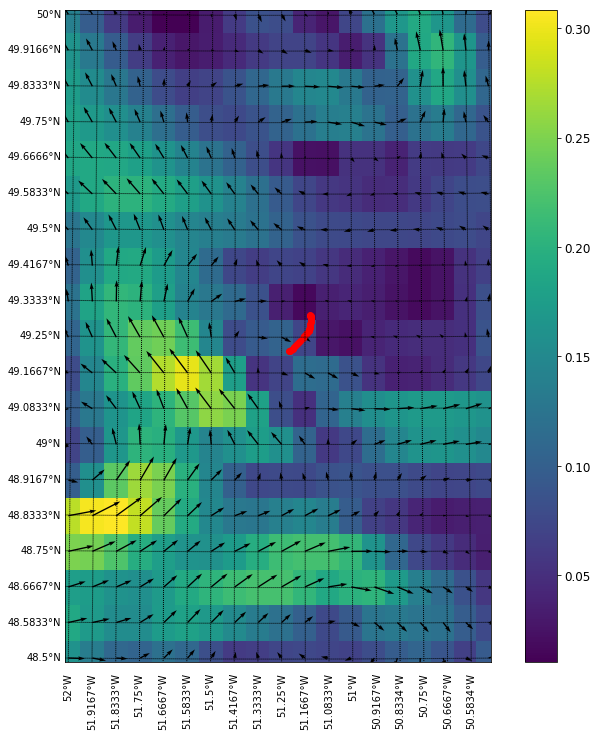

In [55]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds, tc)

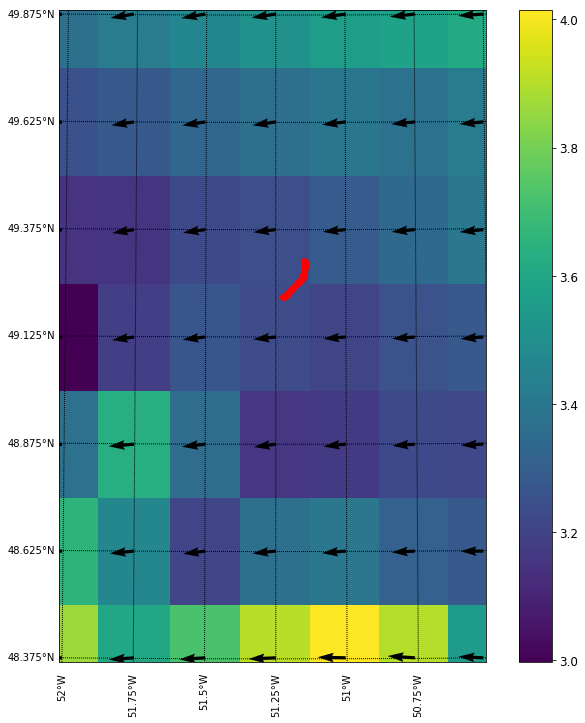

In [56]:
plot_metocean_and_drift_track(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds, tc)

## Find optimal Ca and Cw

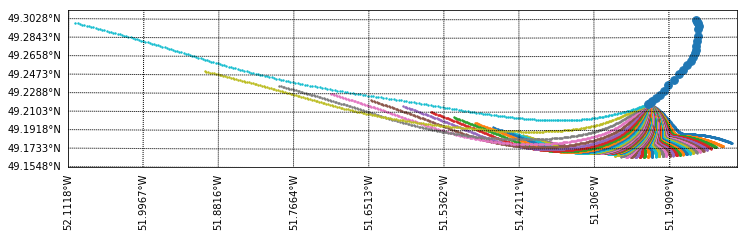

In [19]:
ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
# run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
#                   'perturb_current': True, 'perturb_wind': True,
#                   'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.06773259376122534, Ca: 0.0, Cw: 2.5


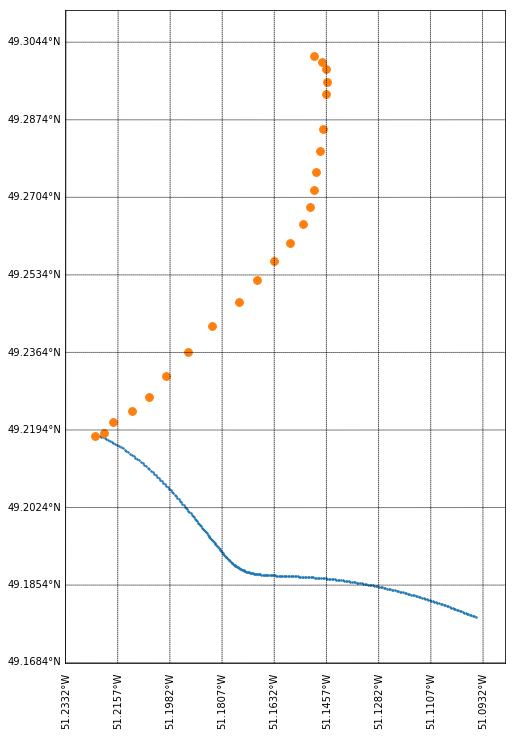

In [20]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

# Day 2

In [21]:
# note index 537 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[537] + np.timedelta64(1, 'D')
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

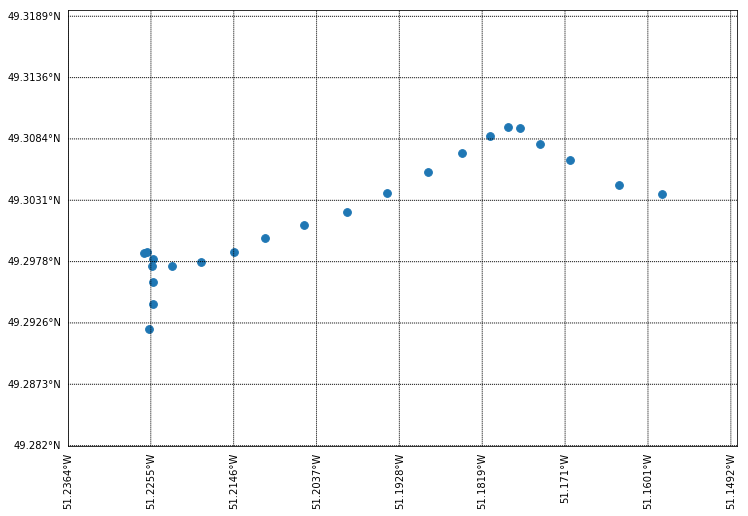

In [22]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

In [23]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc
g = sim.iceberg.geometry
g._size = None
g.sail_height = 12
g.waterline_length = 250
g.mass = 4.2e9

## Plotting metocean data

In [24]:
lon_bounds = (-51.5, -51)
lat_bounds = (49, 49.5)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

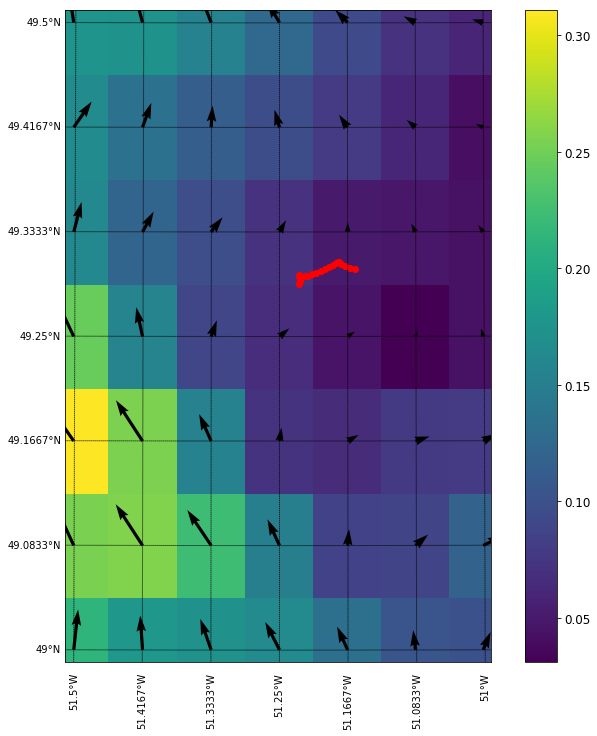

In [25]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds)

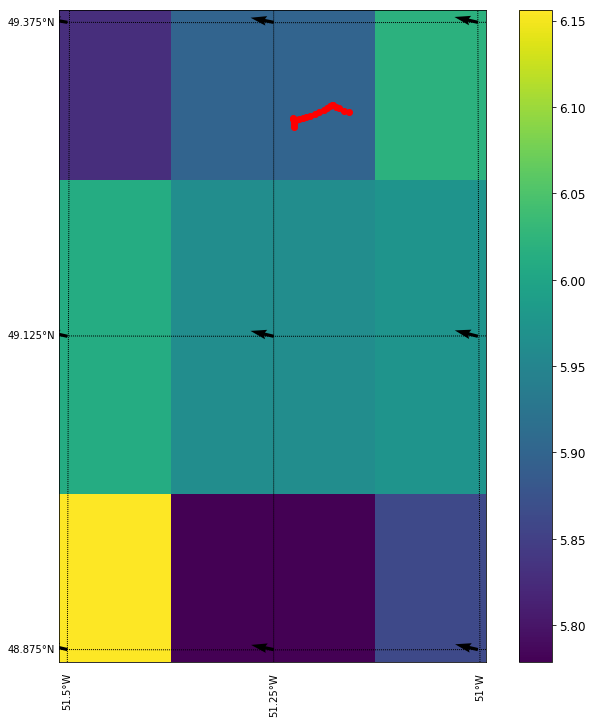

In [26]:
plot_metocean_and_drift_track(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds)

## Find optimal Ca and Cw

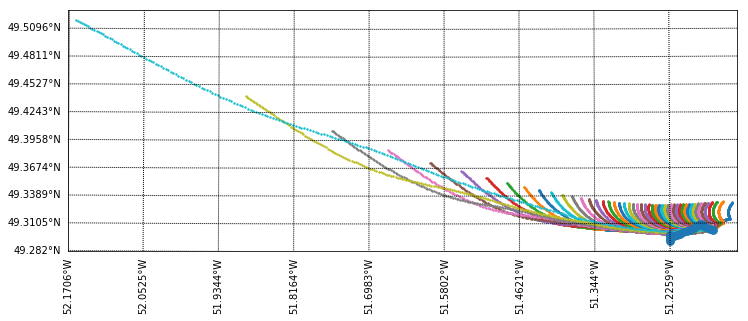

In [27]:
ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
# run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
#                   'perturb_current': True, 'perturb_wind': True,
#                   'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.011976466859117785, Ca: 1.0999999999999999, Cw: 1.4000000000000001


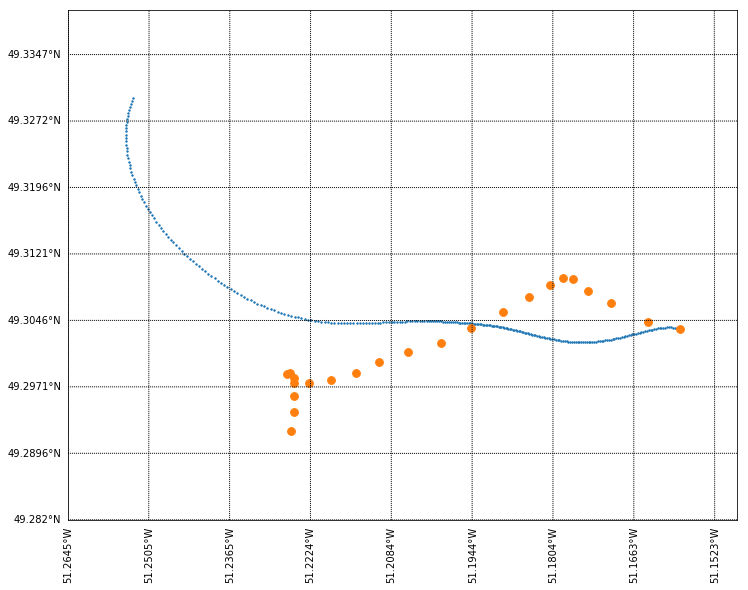

In [28]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

# Day 3

In [8]:
# note index 537 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[537] + np.timedelta64(2, 'D')
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

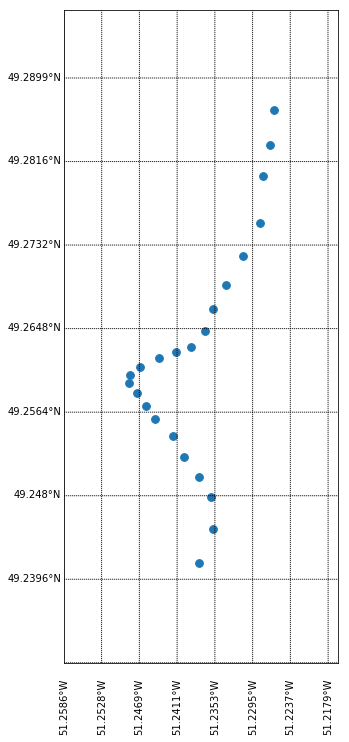

In [9]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

In [10]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc
g = sim.iceberg.geometry
g._size = None
g.sail_height = 12
g.waterline_length = 250
g.mass = 4.2e9

## Plotting metocean data

In [11]:
lon_bounds = (-51.5, -51)
lat_bounds = (49, 49.5)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

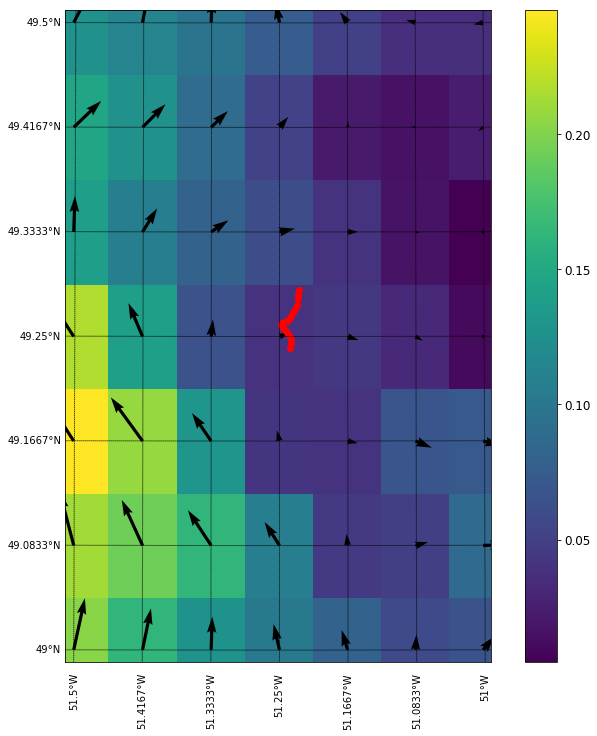

In [12]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds)

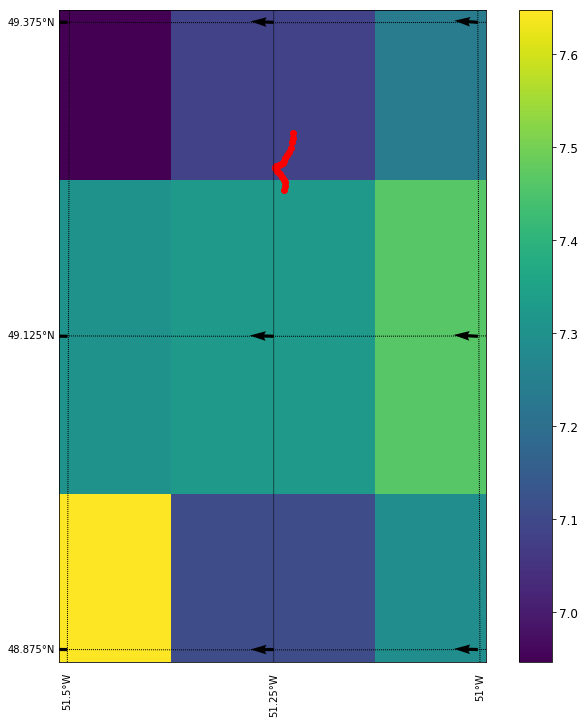

In [13]:
plot_metocean_and_drift_track(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds)

## Find optimal Ca and Cw

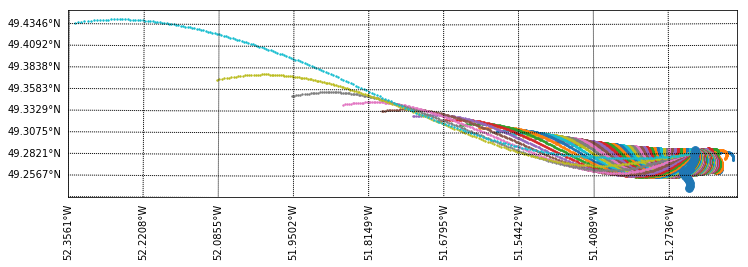

In [14]:
ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
# run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
#                   'perturb_current': True, 'perturb_wind': True,
#                   'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.025229841521844893, Ca: 0.5499999999999999, Cw: 1.9500000000000002


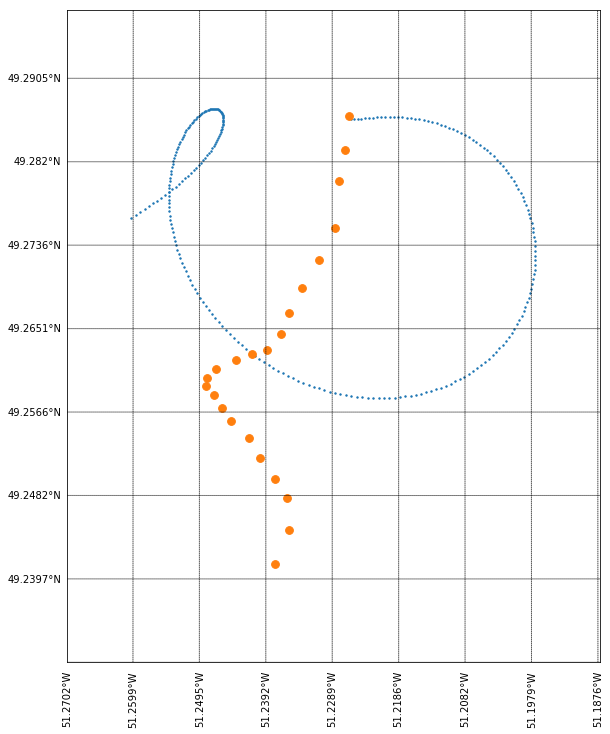

In [15]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

# Day 4

In [16]:
# note index 537 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[537] + np.timedelta64(3, 'D')
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

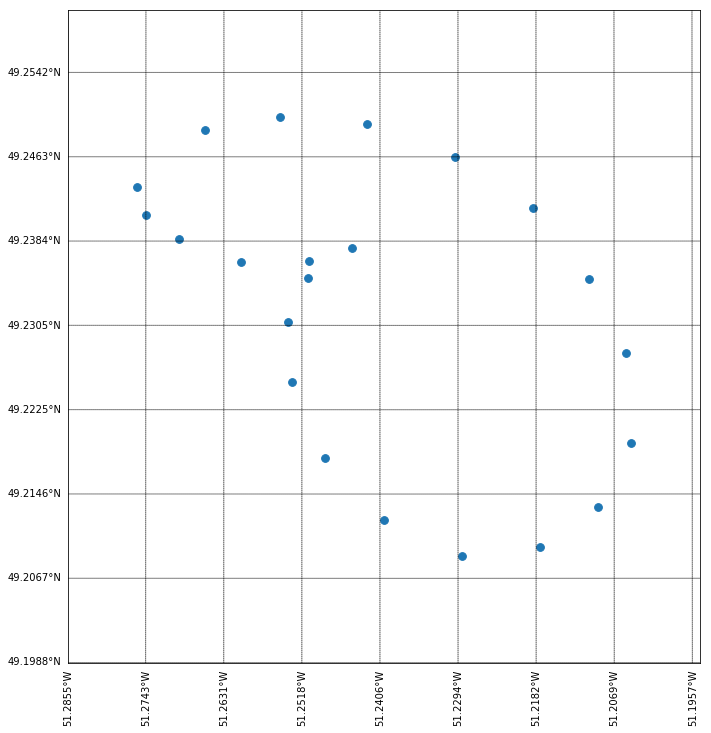

In [17]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

In [18]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc
g = sim.iceberg.geometry
g._size = None
g.sail_height = 12
g.waterline_length = 250
g.mass = 4.2e9

## Plotting metocean data

In [19]:
lon_bounds = (-51.5, -51)
lat_bounds = (49, 49.5)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

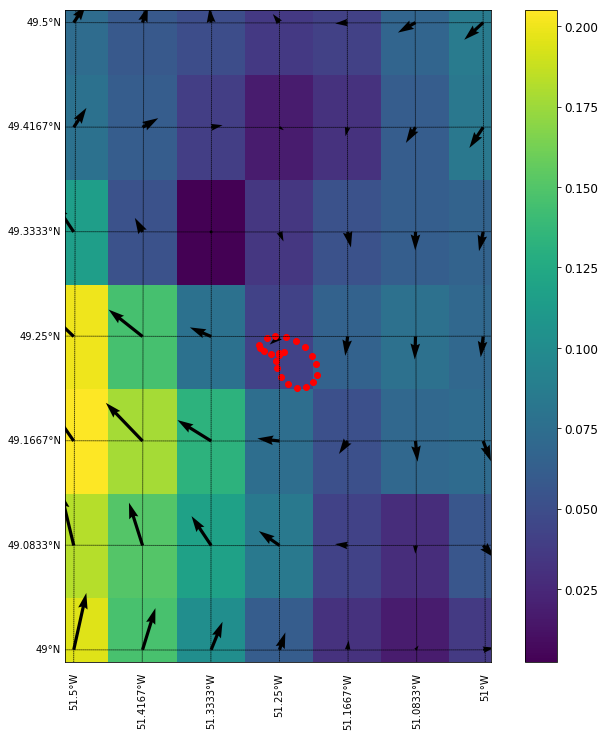

In [20]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds)

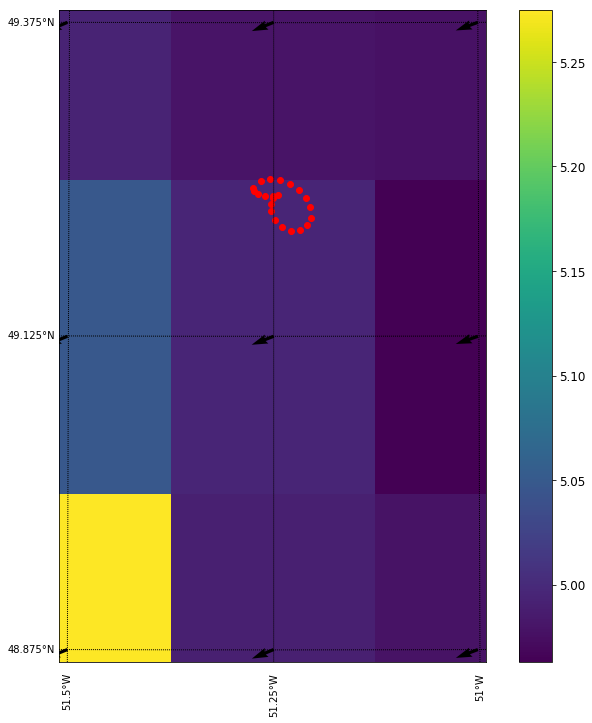

In [21]:
plot_metocean_and_drift_track(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds)

## Find optimal Ca and Cw

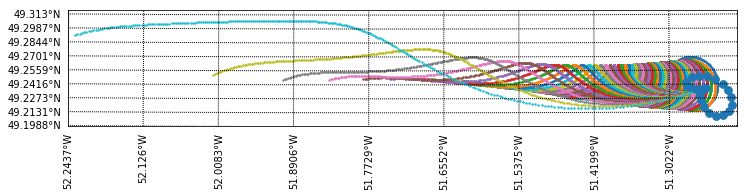

In [22]:
ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
# run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
#                   'perturb_current': True, 'perturb_wind': True,
#                   'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.03027266651605427, Ca: 0.05, Cw: 2.45


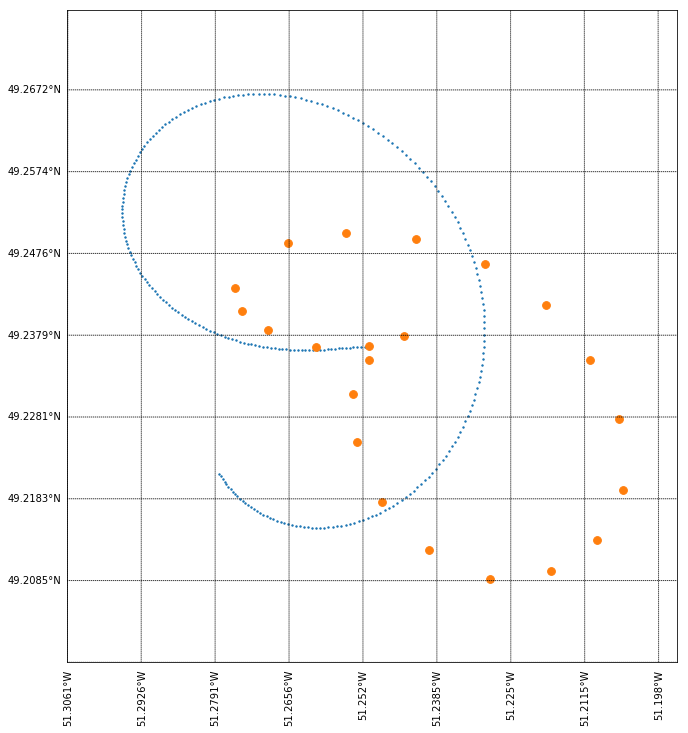

In [23]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

# Day 5

In [6]:
# note index 537 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[537] + np.timedelta64(4, 'D')
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

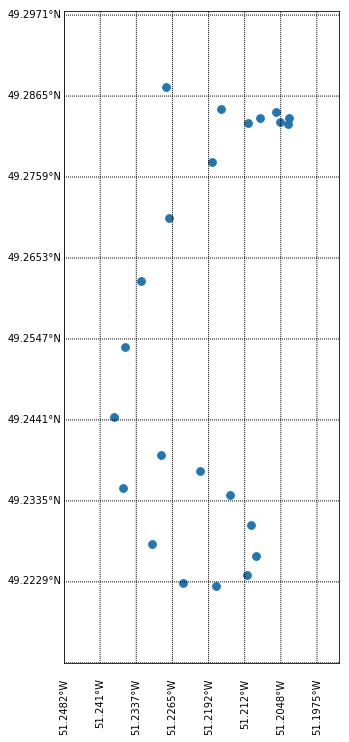

In [7]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

In [8]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc
g = sim.iceberg.geometry
g._size = None
g.sail_height = 12
g.waterline_length = 250
g.mass = 4.2e9

## Plotting metocean data

In [9]:
lon_bounds = (-51.5, -51)
lat_bounds = (49, 49.5)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

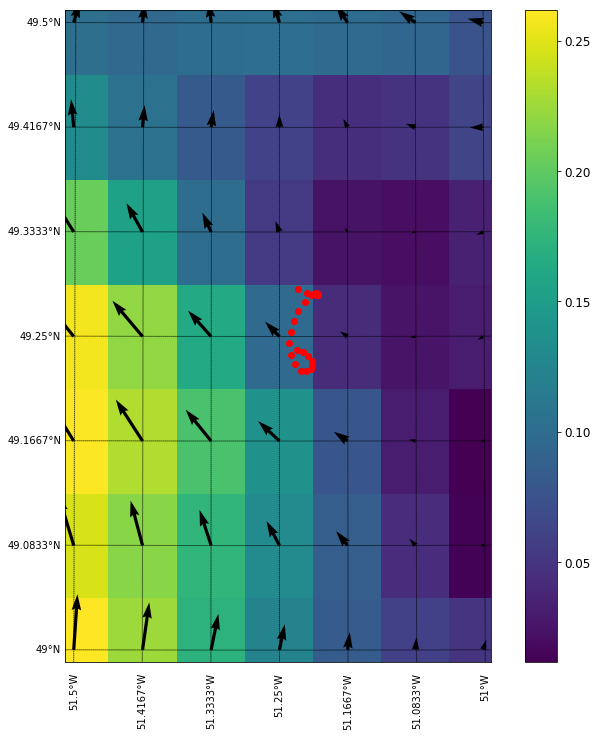

In [10]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds)

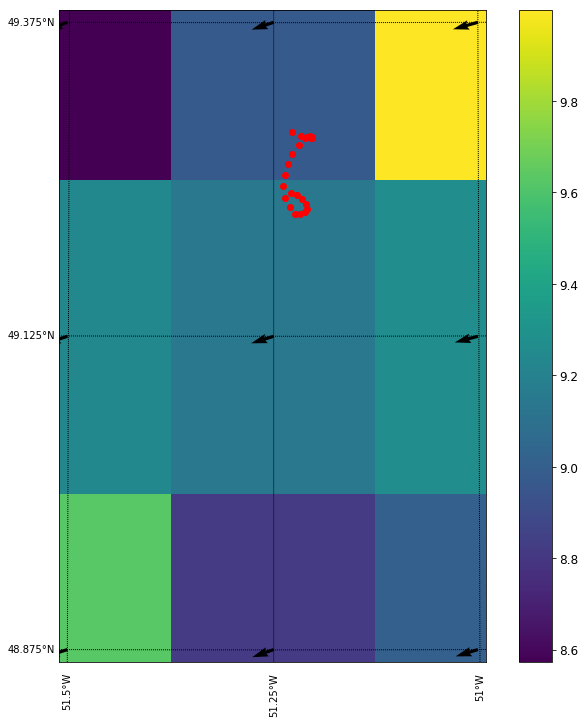

In [11]:
plot_metocean_and_drift_track(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds)

## Find optimal Ca and Cw

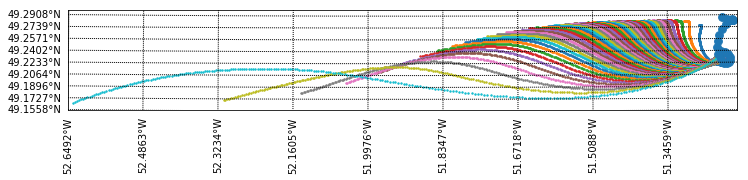

In [12]:
ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
# run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
#                   'perturb_current': True, 'perturb_wind': True,
#                   'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.035898990858360874, Ca: 0.0, Cw: 2.5


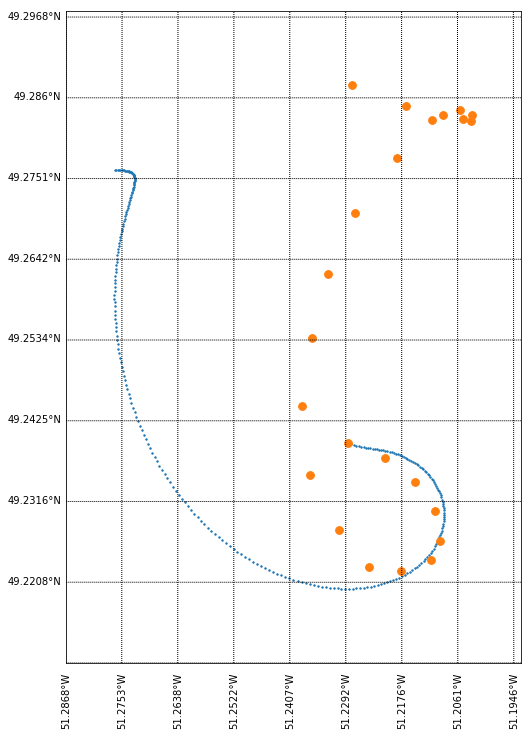

In [13]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

# Day 6

In [14]:
# note index 537 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[537] + np.timedelta64(5, 'D')
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

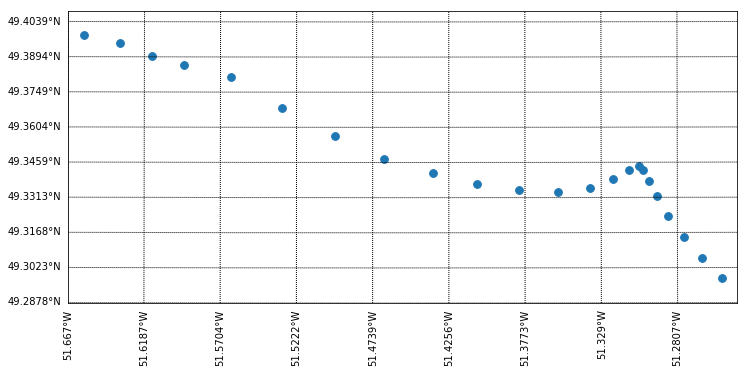

In [15]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

In [16]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc
g = sim.iceberg.geometry
g._size = None
g.sail_height = 12
g.waterline_length = 250
g.mass = 4.2e9

## Plotting metocean data

In [17]:
lon_bounds = (-51.5, -51)
lat_bounds = (49, 49.5)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

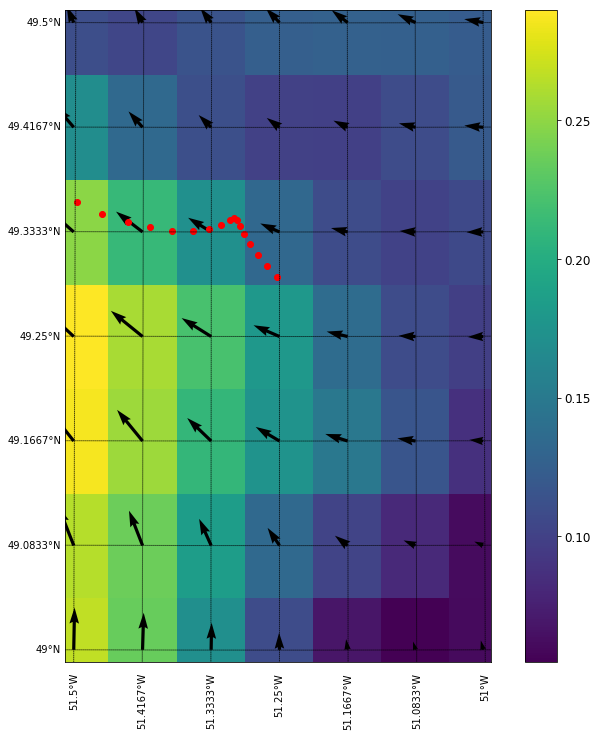

In [18]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds)

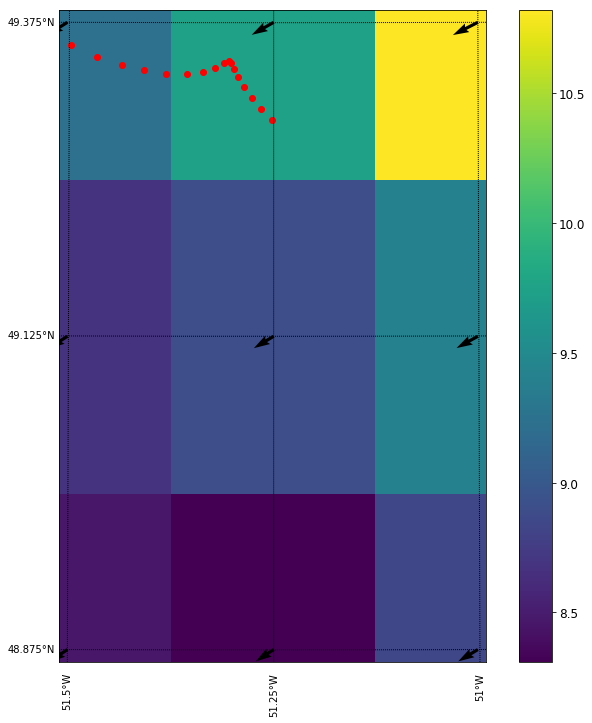

In [19]:
plot_metocean_and_drift_track(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds)

## Find optimal Ca and Cw

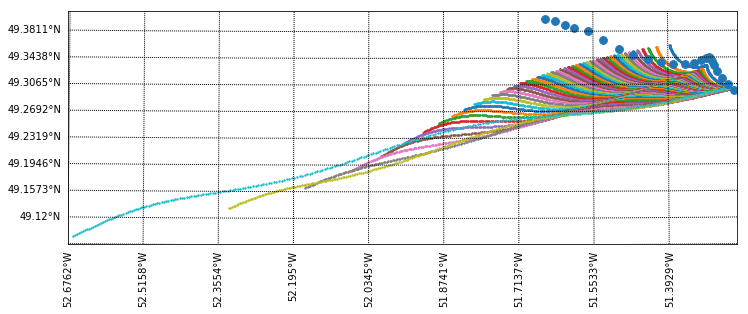

In [20]:
ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
# run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
#                   'perturb_current': True, 'perturb_wind': True,
#                   'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.05565049114896377, Ca: 0.95, Cw: 1.55


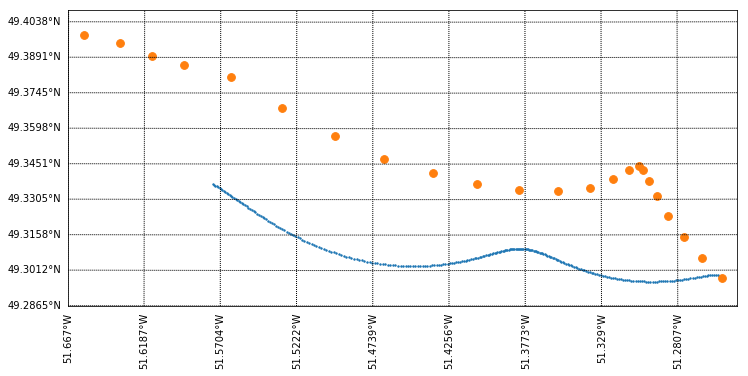

In [21]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

# Day 7

In [7]:
# note index 537 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[537] + np.timedelta64(6, 'D')
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

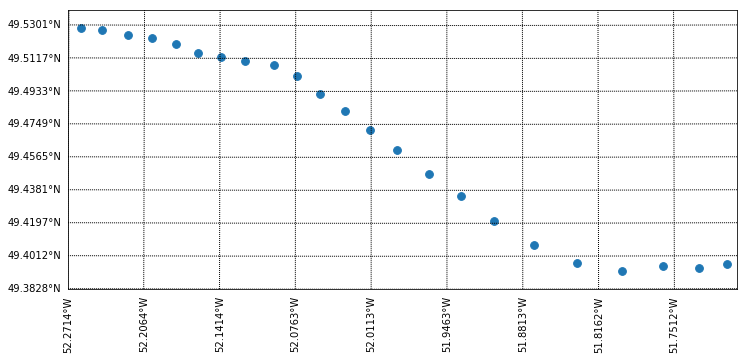

In [8]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

In [9]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc
g = sim.iceberg.geometry
g._size = None
g.sail_height = 12
g.waterline_length = 250
g.mass = 4.2e9

## Plotting metocean data

In [15]:
lon_bounds = (-52.5, -51.5)
lat_bounds = (49, 50)
time_bounds = [tc.ref_times[0], tc.ref_times[-1]]

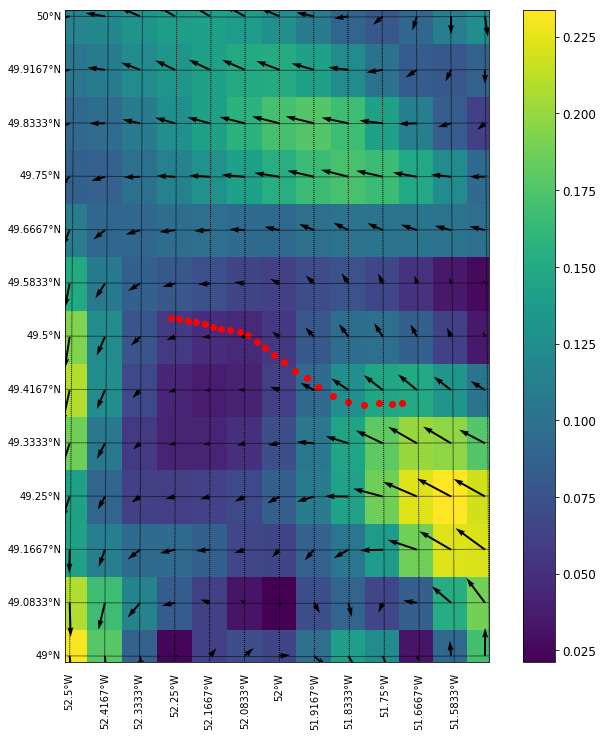

In [16]:
plot_metocean_and_drift_track(sim.ocean, sim.ocean.current, lon_bounds, lat_bounds, time_bounds)

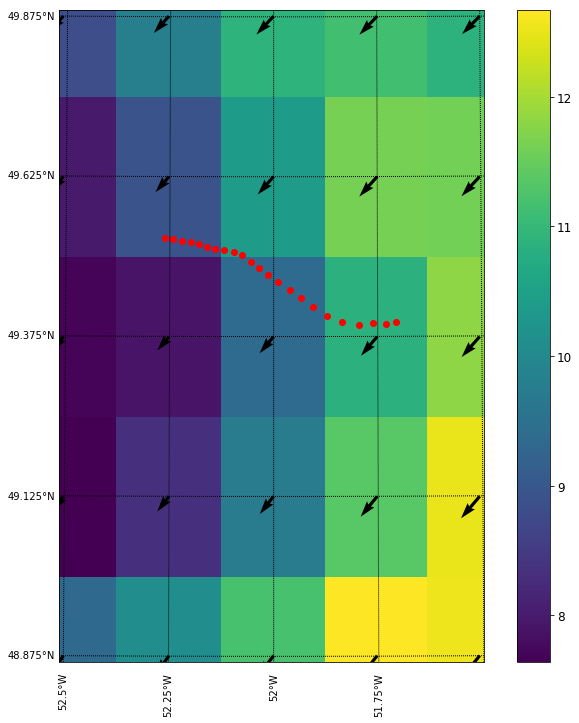

In [17]:
plot_metocean_and_drift_track(sim.atmosphere, sim.atmosphere.wind, lon_bounds, lat_bounds, time_bounds)

## Find optimal Ca and Cw

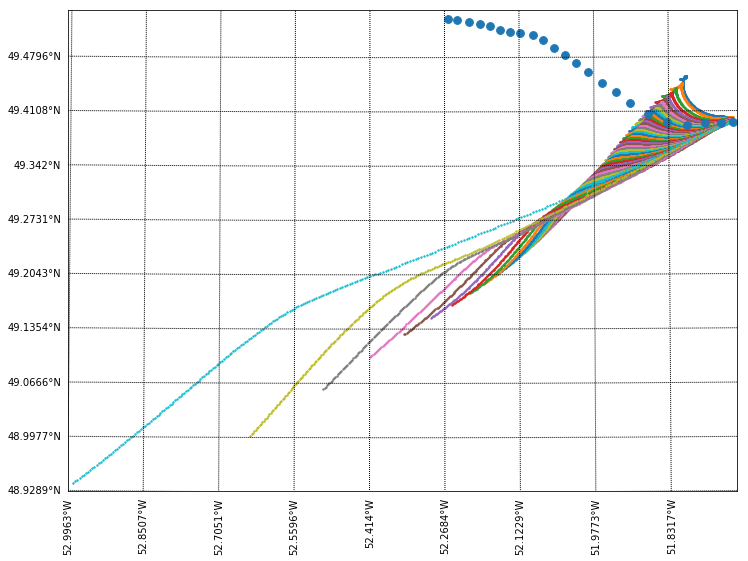

In [13]:
ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
# run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
#                   'perturb_current': True, 'perturb_wind': True,
#                   'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.16652403590675544, Ca: 1.9, Cw: 0.6000000000000001


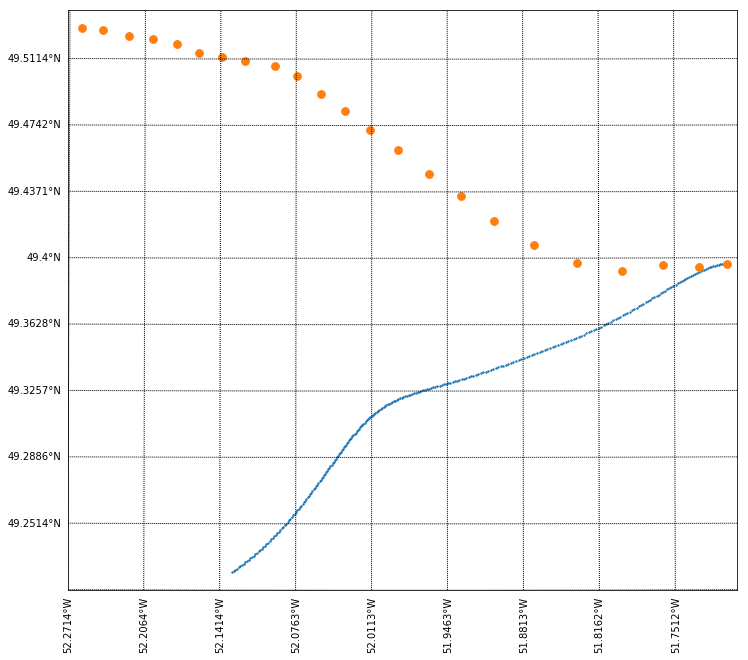

In [14]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)